In [1]:
import cosmopower as cp
import frb_cov as frb
from astropy.io import ascii
import astropy.coordinates as coord
import astropy.units as units
import numpy as np
from astropy.coordinates import Longitude, Latitude
import matplotlib.pyplot as plt
import pandas as pd
import time

bias_emu = cp.cosmopower_NN(restore=True, restore_filename="./../cosmopower/bias_sq_model")
power_emu = cp.cosmopower_NN(restore=True, restore_filename="./../cosmopower/pkmm_nonlin_model")


2024-07-08 11:31:56.226266: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
file_paths = ['./../data/FRBCat_arXiv2307.03344.csv', './../data/FRBCat_arXiv2302.14788.csv', './../data/catalogue_updated.csv']
ra_labels = ['RA (FRB)', 'ra (deg)']
dec_labels = ['Dec (FRB)', 'dec (deg)']
redshift_labels = ['z (host)', 'redshift', 'z_gal']
DM_obs_labels = ['DM (pc/cm3)',"dm", 'DM_obs']
DM_MW_labels = ['DM_ISM (pc/cm3)',"dm_milky_way", 'DM_MW']

ra = []
dec = []
zet = []
DM_obs = []
DM_MW = []
frb_id = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    print(df.keys())
    for keys in ra_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                ra.append(i_aux)
        except:
            continue
    for keys in dec_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                dec.append(i_aux)
        except:
            continue
    for keys in DM_obs_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                DM_obs.append(i_aux)
        except:
            continue
    for keys in redshift_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                zet.append(i_aux)
        except:
            continue
    for keys in DM_MW_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                DM_MW.append(i_aux)
        except:
            continue
ra = np.array(ra)
dec = np.array(dec)
DM_obs = np.array(DM_obs)
DM_MW = np.array(DM_MW)
zet = np.array(zet)
ra = coord.Angle(ra, unit=units.degree)
dec = coord.Angle(dec, unit=units.degree)
ra = ra.radian - np.pi
dec = dec.radian
print(len(DM_MW))

idx = np.where(DM_obs>1000)[0]
idx = np.append(idx,[11,12,17,20])
DM_obs = np.delete(DM_obs,idx)
zet = np.delete(zet,idx)
ra = np.delete(ra,idx)
dec = np.delete(dec,idx)
DM_MW = np.delete(DM_MW,idx)


Index(['Unnamed: 0', 'FRB', 'Time', 'RA (FRB)', 'Dec (FRB)', 'S/N', 'Fluence',
       'DM (pc/cm3)', 'DMErr (pc/cm3)', 'DM_ISM (pc/cm3)', 'Width (ms)',
       'z (host)', 'M_r (host)', 'g-r (host)', 'log(M_*) (Msun) (host)',
       'SFR 100 Myr (Msun/yr) (host)', 't_m (Gyr) (host)',
       'L_PRS (erg/s/Hz) (host)', 'Host Name', 'RA (host)', 'Dec (host)',
       'm_r (mag) (host)', 'r_e (arcsec) (host)', 'Source', 'P_host'],
      dtype='object')
Index(['Unnamed: 0', 'FRB', 'RA (FRB)', 'Dec (FRB)', 'z_gal', 'DM_obs',
       'DM_MW', 'RM_obs', 'tau (ms)', 'F (Jy ms)', 'b (kpc)', 'z_gal (gal)',
       'RA (gal)', 'Dec (gal)', 'D_L [Mpc] (gal)', 'd [kpc] (gal)',
       'r_e [kpc] (gal)', 'log(M_star) [M_Sun] (gal)', 'SFR (gal)',
       'log(sSFR) [Gyr^-1] (gal)', 'log(z/z_Sun) (gal)', 'A_V (gal)',
       '$U_neb (gal)', 'u - r  (gal)', 'g - r (gal)', 'M_r (gal)',
       'Milky Way E(B - V) (gal)', 'RA (clust)', 'Dec (clust)', 'Richness',
       'z_clust', 'M_500 (M_Sun) (clust)', 'R_500 (

In [13]:
sigma8 = 0.834
h = 0.674
omegam = 0.3
omegab = 0.05
omegade = 1.0 - omegam
w0 = -1
wa = 0
ns = 0.963
neff = 3.046
mnu = 0
Tcmb0 = 2.725
alpha_B = 0.5
alpha_M = 0.5
log_TAGN = 7.8
ks = 1
keys = ['sigma_8', 'h', 'omega_m', 'omega_b', 'omega_de', 'w0', 'wa',
        'ns', 'neff', 'm_nu', 'Tcmb0', 'alpha_B', 'alpha_M', 'logTAGN', 'ks']
values = [sigma8, h, omegam, omegab, omegade,
          w0, wa,  ns, neff, mnu, Tcmb0, alpha_B, alpha_M, log_TAGN, ks]
cosmo = dict(zip(keys, values))
n_with_host = len(zet)
print(n_with_host)
'''frb_cat = ascii.read("./../data/catalogue_updated.csv", data_start=1)
ra = coord.Angle(frb_cat["ra (deg)"], unit=units.degree)
dec = coord.Angle(frb_cat["dec (deg)"], unit=units.degree)
ra = ra.radian - np.pi
dec = dec.radian
counts = len(frb_cat["redshift"])

zet = frb_cat["redshift"][:n_with_host]
z = np.zeros(n_with_host)
DM_obs = np.zeros(n_with_host)
for i in range(len(zet)):
    z[i] = zet[i]
    sep = '&'
    DM_obs[i] = frb_cat["dm"][i]
ra = ra[:n_with_host]
dec = dec[:n_with_host]
'''
z = np.zeros(n_with_host)
for i in range(len(zet)):
    z[i] = zet[i]
delta_theta = np.zeros((n_with_host, n_with_host))
for i in range(n_with_host):
    for j in range(n_with_host):
        if (i != j):
            if(np.abs(((DM_obs[i] - DM_obs[j])/DM_obs[i]))<0.01 and i < j):
                print(((DM_obs[i] - DM_obs[j])/DM_obs[i]),i,j)
            delta_theta[i, j] = np.arccos(np.sin(
                ra[i])*np.sin(ra[j]) + np.cos(ra[i])*np.cos(ra[j])*np.cos(dec[i] - dec[j]))



20


In [27]:

def gaussian_loglike(params):
    sigma_mw = 30.0
    sigma_host = 50.0
    DM_host = params['DM_host']
    A = params['A']
    # mean DM is LSS contribution
    cosmo['alpha_B'] = params['alpha_B']
    cosmo['alpha_M'] = params['alpha_M']
    cov = frb.covariance_frb_background(cosmo,bias_emu,power_emu,z,delta_theta,300)
    result = 0.0
    DM_mean = A*cov.DM + DM_host/(1.+z) + DM_MW
    cov_mat = A**2*cov.covariance + np.diag((sigma_host/(1.+z)))**2 + np.diag(sigma_mw*np.ones(len(z)))**2 
    precision_mat = np.linalg.inv(cov_mat)
    log_det_cov = np.linalg.slogdet(cov_mat)[1]
    delta = DM_obs - DM_mean
    quadraticform = np.einsum(
        'i,i', delta, np.einsum('ij,j', precision_mat, delta))
    result = -.5*(log_det_cov) - .5*quadraticform  
    return result*500

def pdf_log_normal(x, mu, sigma):
    return 1./(x*sigma*np.sqrt(np.pi))*np.exp(-(np.log(x) - mu)**2/2/sigma**2)

def LSS_likelihood(DM_LSS, DM_mean, precision_mat, log_det_cov):
    delta = DM_LSS - DM_mean
    quadraticform = np.einsum(
        'i,i', delta, np.einsum('ij,j', precision_mat, delta))
    result = -.5*(log_det_cov) - .5*quadraticform
    return np.exp(result)


def final_likelihood(params):
    sigma_host = 0.6
    DM_host = np.log(50)
    sigma_mw = 30.0
    A = params['A']
    # mean DM is LSS contribution
    cosmo['alpha_B'] = params['alpha_B']
    cosmo['alpha_M'] = params['alpha_M']
    cov = frb.covariance_frb_background(cosmo,bias_emu,power_emu,z,delta_theta,300)
    DM_mean = A*cov.DM + DM_MW
    cov_mat = A**2*cov.covariance + np.diag(sigma_mw*np.ones(len(z)))**2 
    precision_mat = np.linalg.inv(cov_mat)
    log_det_cov = np.linalg.slogdet(cov_mat)[1]
    N_int = 200
    X_DM_host = np.linspace(1, 1000, N_int)
    integrand = np.zeros_like(X_DM_host)
    for i in range(N_int):
        integrand[i] = LSS_likelihood(
            DM_obs - X_DM_host[i]/(1.0+z), DM_mean, precision_mat, log_det_cov)*pdf_log_normal(X_DM_host[i], DM_host, sigma_host)
    result = np.trapz(integrand, X_DM_host)
    return np.log(result)*500


def calc_model(params):
    sigma_mw = 30.0
    sigma_host = 50.0
    DM_host = params['DM_host']
    A = params['A']
    # mean DM is LSS contribution
    cosmo['alpha_B'] = params['alpha_B']
    cosmo['alpha_M'] = params['alpha_M']
    cov = frb.covariance_frb_background(cosmo,bias_emu,power_emu,z,delta_theta,300)
    cov_mat = A**2*cov.covariance + np.diag((sigma_host/(1.+z)))**2 + np.diag(sigma_mw*np.ones(len(z)))**2 
    delta = DM_obs - DM_MW - A*cov.DM - DM_host/(1.+z)
    return A*cov.DM + DM_host/(1.+z), np.diag(np.sqrt(cov_mat)), np.dot(delta,np.dot(np.linalg.inv(cov_mat),delta))/len(delta)





In [28]:
alpha_B = np.linspace(0,3,100)
alpha_M = np.linspace(0,3,100)

loglike_alpha_B = np.zeros_like(alpha_B)
loglike_alpha_M = np.zeros_like(alpha_B)
loglike_alpha_B_ln = np.zeros_like(alpha_B)
loglike_alpha_M_ln = np.zeros_like(alpha_B)

params = {'A':1,'DM_host':50,'alpha_B':0.05, 'alpha_M' : 0.05}

for i in range(len(alpha_B)):
    print(i)
    params['alpha_B'] = alpha_B[i]
    params['alpha_M'] = 0.05
    if alpha_B[i] < 2.5:
        loglike_alpha_B[i] = gaussian_loglike(params)
        loglike_alpha_B_ln[i] = final_likelihood(params)
    else:
        loglike_alpha_B[i] = -200
        loglike_alpha_B_ln[i] = -200
    
    params['alpha_M'] = alpha_M[i]
    params['alpha_B'] = 0.05
    loglike_alpha_M[i] = gaussian_loglike(params)
    loglike_alpha_M_ln[i] = final_likelihood(params)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [29]:

fig, ax = plt.subplots()

fontsi = 16
fontsi2 = 22

plt.tick_params(labelsize=fontsi)


plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('image', interpolation='none')

plt.plot(alpha_B, np.exp(loglike_alpha_B - np.min(loglike_alpha_B)), label = r"$\hat{\alpha}_\mathrm{B}$")
plt.plot(alpha_M, np.exp(loglike_alpha_M - np.min(loglike_alpha_M)), label = r"$\hat{\alpha}_\mathrm{M}$")

plt.plot(alpha_B, np.exp(loglike_alpha_B_ln - np.min(loglike_alpha_B_ln)), color = "blue", ls = "--")
plt.plot(alpha_M, np.exp(loglike_alpha_M_ln - np.min(loglike_alpha_M_ln)), color = "orange", ls = "--")

plt.xlabel(r"$\hat{\alpha}_i$", fontsize = fontsi2)
plt.ylabel(r"$\mathrm{posterior}$", fontsize = fontsi2)

plt.legend(fontsize = fontsi2, frameon = False)
plt.xlim(0,3.)
plt.tight_layout()
plt.savefig("fit_host_frb.pdf")


Error in callback <function flush_figures at 0x198ebaf20> (for post_execute):


KeyboardInterrupt: 

/var/folders/c4/9sgp4_xd5j3bblrqkdwx645r0000gn/T/ipykernel_95566/742222708.py:66: RuntimeWarning: invalid value encountered in sqrt
  return A*cov.DM + DM_host/(1.+z), np.diag(np.sqrt(cov_mat)), np.dot(delta,np.dot(np.linalg.inv(cov_mat),delta))/len(delta)


1.2631845774006725


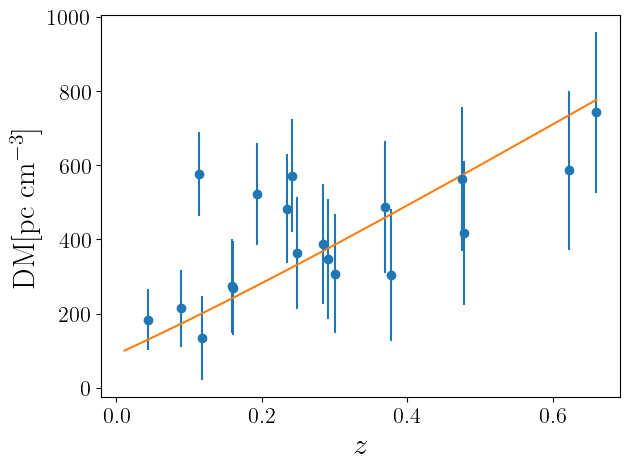

In [26]:
fig, ax = plt.subplots()

fontsi = 16
fontsi2 = 22

plt.tick_params(labelsize=fontsi)


plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('image', interpolation='none')

params = {'A':1.1,'DM_host':90,'alpha_B':0.05, 'alpha_M' : 0.05}

model, error, chi2 = calc_model(params)
print(chi2)

idx = np.where(DM_obs - DM_MW > 0)[0]


plt.errorbar(z[idx], DM_obs[idx] - DM_MW[idx] , error[idx], ls ="", marker = "o")
plt.plot(np.sort(z), np.sort(model) )
plt.xlabel("$z$", fontsize = fontsi2)
plt.ylabel("$\mathrm{DM} [\mathrm{pc}\;\mathrm{cm}^{-3}]$", fontsize = fontsi2)

plt.tight_layout()
plt.savefig("model.pdf")


In [8]:
from scipy.stats import norm
from nautilus import Prior
from nautilus import Sampler

prior = Prior()
prior.add_parameter('alpha_B', dist=(0, 2.5))
prior.add_parameter('alpha_M', dist=(0, 3))
prior.add_parameter('A', dist=(0.5,10))
prior.add_parameter('DM_host', dist=(10,500))


sampler = Sampler(prior, gaussian_loglike, n_live=100, filepath='sampling_100.hdf5')
sampler.run(verbose=True)


Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 16     | 1        | 4        | 13700    | N/A    | 10072 | -13411.78


(array([0.010938  , 0.01169948, 0.01663593, 0.01990546, 0.02123789,
        0.02264037, 0.02431976, 0.02990346, 0.0301291 , 0.03719258,
        0.04341719, 0.04340533, 0.04570413, 0.04882607, 0.05692185,
        0.0579252 , 0.06239415, 0.06271223, 0.05552515, 0.05363873,
        0.04970588, 0.04075964, 0.03986504, 0.03283083, 0.02849487,
        0.02253242, 0.01207352, 0.0093144 , 0.0062106 , 0.00314073]),
 array([7.45277991e-04, 8.40398113e-02, 1.67334345e-01, 2.50628878e-01,
        3.33923411e-01, 4.17217944e-01, 5.00512478e-01, 5.83807011e-01,
        6.67101544e-01, 7.50396077e-01, 8.33690611e-01, 9.16985144e-01,
        1.00027968e+00, 1.08357421e+00, 1.16686874e+00, 1.25016328e+00,
        1.33345781e+00, 1.41675234e+00, 1.50004688e+00, 1.58334141e+00,
        1.66663594e+00, 1.74993048e+00, 1.83322501e+00, 1.91651954e+00,
        1.99981408e+00, 2.08310861e+00, 2.16640314e+00, 2.24969768e+00,
        2.33299221e+00, 2.41628674e+00, 2.49958128e+00]),
 <BarContainer object of 30 

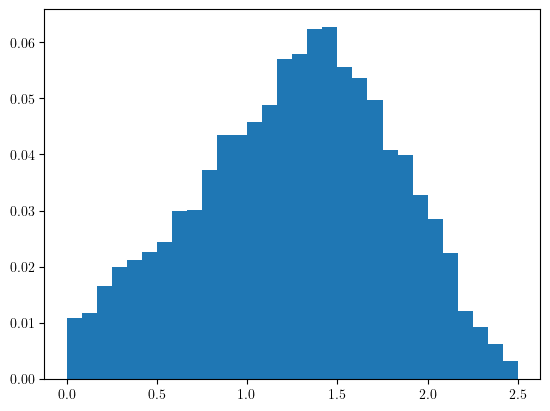

In [9]:
points, log_w, log_l = sampler.posterior()
plt.hist(points[:,0], bins = 30, weights=np.exp(log_w))

In [10]:
s = np.random.normal(100, 50, 10000)